In [1]:
!pip install -U accelerate transformers datasets soundfile speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 59.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.0
    Uninstalling fsspec-2024.3.0:
      Successfully uninstalled fsspec-2024.3.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the package

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, Audio
from transformers import (AutoProcessor
                          , SpeechT5ForTextToSpeech
                          , Seq2SeqTrainingArguments
                          , Seq2SeqTrainer)
from collections import defaultdict
from speechbrain.inference.speaker import EncoderClassifier
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from functools import partial

from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [53]:
dataset = load_dataset("facebook/voxpopuli"
                       , "lt"
                       , split="train"
                       , trust_remote_code=True
                       , streaming=True)

In [41]:
checkpoint = "microsoft/speecht5_tts"
processor = AutoProcessor.from_pretrained(checkpoint)

In [54]:
sampling_rate = processor.feature_extractor.sampling_rate
dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [43]:
next(iter(dataset))

{'audio_id': '20191217-0900-PLENARY-lt_20191217-22:09:06_1',
 'language': 15,
 'audio': {'path': 'train_part_0/20191217-0900-PLENARY-lt_20191217-22:09:06_1.wav',
  'array': array([0.02304077, 0.03216553, 0.02148438, ..., 0.00292969, 0.01467896,
         0.01254272]),
  'sampling_rate': 16000},
 'raw_text': 'Skaitmeninės sveikatos priežiūros sistema suteikia galimybės plėtoti dirbtinio intelekto bei kompiuterinio mokymosi panaudojimą. Naujos technologijos pritaikytos sveikatos priežiūros sistemai gali padėti geriau suprasti sunkiai pagydomas ligas bei kitus sveikatos sutrikimus.',
 'normalized_text': 'skaitmeninės sveikatos priežiūros sistema suteikia galimybės plėtoti dirbtinio intelekto bei kompiuterinio mokymosi panaudojimą. naujos technologijos pritaikytos sveikatos priežiūros sistemai gali padėti geriau suprasti sunkiai pagydomas ligas bei kitus sveikatos sutrikimus.',
 'gender': 'male',
 'speaker_id': '197841',
 'is_gold_transcript': True,
 'accent': 'None'}

In [44]:
tokenizer = processor.tokenizer

In [86]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    #keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(j for i in vocabs for j in i["vocab"])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [87]:
dataset_vocab - tokenizer_vocab

{' ', 'ą', 'č', 'ė', 'ę', 'į', 'š', 'ū', 'ų', 'ž'}

In [88]:
replacements = [
    ("ą","a")
    , ("č", "c")
    , ("ė", "e")
    , ("ę", "e")
    , ("į", "j")
    , ("š", "s")
    , ("ū", "u")
    , ("ų", "u")
    , ("ž", "z")
]
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

In [89]:
speaker_counts = defaultdict(int)
for x in dataset:
    speaker_counts[x["speaker_id"]] += 1

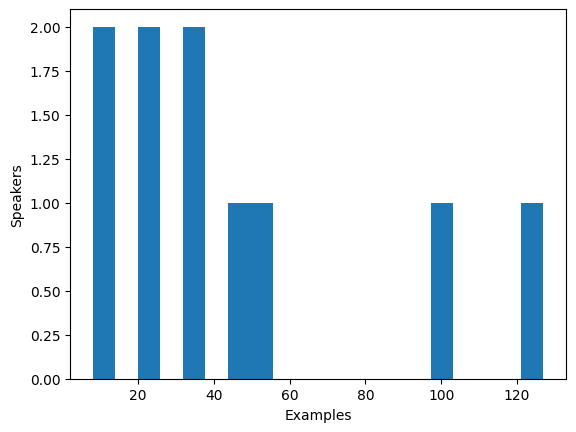

In [90]:
plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [91]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [116]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [119]:
processed_example = prepare_dataset(next(iter(dataset)))
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [120]:
processed_example["speaker_embeddings"].shape

(512,)

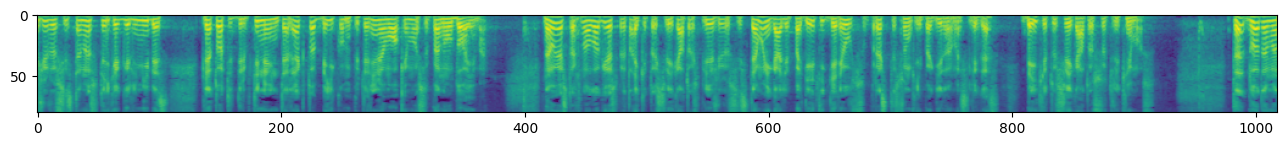

In [102]:
plt.figure(figsize = (16, 9))
plt.imshow(processed_example["labels"].T)
plt.show()

In [117]:
test = dataset.map(prepare_dataset
#                    , batched=True
#                    , batch_size=-1
                   , remove_columns=dataset.column_names)